# **Imports**

In [ ]:
# ----------------------------
# 1. Imports
# ----------------------------
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from pathlib import Path

import tensorflow as tf
from tensorflow.keras import layers, models, utils, callbacks, optimizers
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Fix random seeds for reproducibility (not strictly deterministic across hardware)
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

# ----------------------------
# 2. Config
# ----------------------------
OUT_DIR = Path("output")
OUT_DIR.mkdir(exist_ok=True)
MODEL_PATH = OUT_DIR / "mnist_cnn.h5"
BATCH_SIZE = 128
EPOCHS = 15
IMG_ROWS, IMG_COLS = 28, 28
NUM_CLASSES = 10

# **Load dataset (MNIST)**

Train shape: (60000, 28, 28) (60000,)
Test shape: (10000, 28, 28) (10000,)


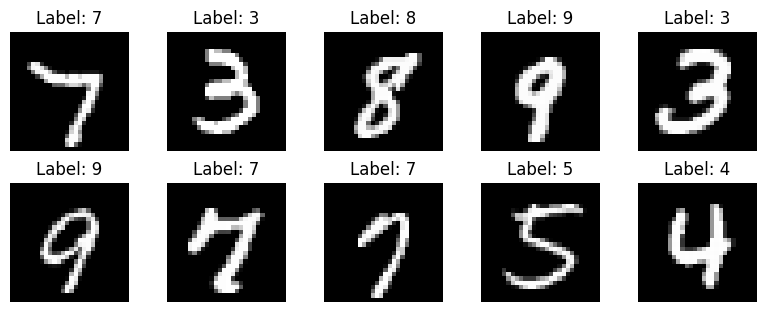

In [ ]:
# ----------------------------
# 3. Load dataset (MNIST)
# ----------------------------
from tensorflow.keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
print("Train shape:", x_train.shape, y_train.shape)
print("Test shape:", x_test.shape, y_test.shape)

# ----------------------------
# 4. Visualize samples
# ----------------------------
def show_samples(X, y, rows=2, cols=5):
    plt.figure(figsize=(cols*1.6, rows*1.6))
    idxs = np.random.choice(range(len(X)), rows*cols, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(rows, cols, i+1)
        plt.imshow(X[idx], cmap="gray")
        plt.title(f"Label: {y[idx]}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

show_samples(x_train, y_train, rows=2, cols=5)

# **Preprocess data**

In [ ]:
# ----------------------------
# 5. Preprocess data
# ----------------------------
# Normalize and reshape to (28,28,1)
x_train = x_train.astype("float32") / 255.0
x_test  = x_test.astype("float32")  / 255.0

# Add channel dimension
x_train = np.expand_dims(x_train, -1)  # shape: (N,28,28,1)
x_test  = np.expand_dims(x_test, -1)

# Convert labels to categorical
y_train_cat = utils.to_categorical(y_train, NUM_CLASSES)
y_test_cat  = utils.to_categorical(y_test, NUM_CLASSES)

print("After preprocess:", x_train.shape, y_train_cat.shape)

# ----------------------------
# 6. Split validation set from training (optional)
# ----------------------------
from sklearn.model_selection import train_test_split
x_train, x_val, y_train_cat, y_val_cat, y_train, y_val = train_test_split(
    x_train, y_train_cat, y_train, test_size=0.2, random_state=SEED, stratify=y_train
)
print("Train:", x_train.shape, "Val:", x_val.shape)

After preprocess: (60000, 28, 28, 1) (60000, 10)
Train: (48000, 28, 28, 1) Val: (12000, 28, 28, 1)


# **Model Building**

In [ ]:
# ----------------------------
# 7. Build CNN Model
# ----------------------------
def build_cnn(input_shape=(28,28,1), num_classes=10):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(128, (3,3), activation='relu'),
        layers.BatchNormalization(),
        layers.Flatten(),
        layers.Dropout(0.4),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

model = build_cnn(input_shape=(IMG_ROWS, IMG_COLS, 1), num_classes=NUM_CLASSES)
model.summary()

# ----------------------------
# 8. Compile model
# ----------------------------
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# ----------------------------
# 9. Callbacks
# ----------------------------
cb = [
    callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    callbacks.ModelCheckpoint(str(MODEL_PATH), monitor='val_loss', save_best_only=True)
]

# ----------------------------
# 10. Data augmentation (optional)
# ----------------------------
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.08,
    height_shift_range=0.08,
    shear_range=0.08,
    zoom_range=0.08
)
datagen.fit(x_train)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 26, 26, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 11, 11, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 3, 3, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 242,954 (949.04 KB)

 Trainable params: 242,250 (946.29 KB)

 Non-trainable params: 704 (2.75 KB)

# **Model Training**

In [ ]:
# ----------------------------
# 11. Train
# ----------------------------
history = model.fit(
    datagen.flow(x_train, y_train_cat, batch_size=BATCH_SIZE),
    steps_per_epoch = max(1, len(x_train)//BATCH_SIZE),
    epochs=EPOCHS,
    validation_data=(x_val, utils.to_categorical(y_val, NUM_CLASSES)),
    callbacks=cb,
    verbose=2
)

# Save final model (redundant with ModelCheckpoint but safe)
model.save(MODEL_PATH)
print("Saved model to:", MODEL_PATH)

Epoch 1/15


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


375/375 - 24s - 65ms/step - accuracy: 0.9078 - loss: 0.2983 - val_accuracy: 0.4588 - val_loss: 1.6921
Epoch 2/15


375/375 - 15s - 41ms/step - accuracy: 0.9700 - loss: 0.0990 - val_accuracy: 0.9821 - val_loss: 0.0565
Epoch 3/15
375/375 - 15s - 39ms/step - accuracy: 0.9756 - loss: 0.0797 - val_accuracy: 0.9747 - val_loss: 0.0855
Epoch 4/15


375/375 - 15s - 40ms/step - accuracy: 0.9792 - loss: 0.0672 - val_accuracy: 0.9851 - val_loss: 0.0465
Epoch 5/15
375/375 - 15s - 41ms/step - accuracy: 0.9824 - loss: 0.0577 - val_accuracy: 0.9850 - val_loss: 0.0521
Epoch 6/15


375/375 - 15s - 40ms/step - accuracy: 0.9840 - loss: 0.0514 - val_accuracy: 0.9894 - val_loss: 0.0355
Epoch 7/15
375/375 - 23s - 62ms/step - accuracy: 0.9847 - loss: 0.0478 - val_accuracy: 0.9825 - val_loss: 0.0532
Epoch 8/15


375/375 - 15s - 39ms/step - accuracy: 0.9853 - loss: 0.0484 - val_accuracy: 0.9898 - val_loss: 0.0332
Epoch 9/15


375/375 - 15s - 39ms/step - accuracy: 0.9864 - loss: 0.0444 - val_accuracy: 0.9922 - val_loss: 0.0245
Epoch 10/15
375/375 - 16s - 42ms/step - accuracy: 0.9871 - loss: 0.0412 - val_accuracy: 0.9908 - val_loss: 0.0306
Epoch 11/15
375/375 - 15s - 40ms/step - accuracy: 0.9875 - loss: 0.0392 - val_accuracy: 0.9919 - val_loss: 0.0280
Epoch 12/15
375/375 - 15s - 40ms/step - accuracy: 0.9881 - loss: 0.0375 - val_accuracy: 0.9925 - val_loss: 0.0249


Saved model to: output/mnist_cnn.h5


# **Visulaization**

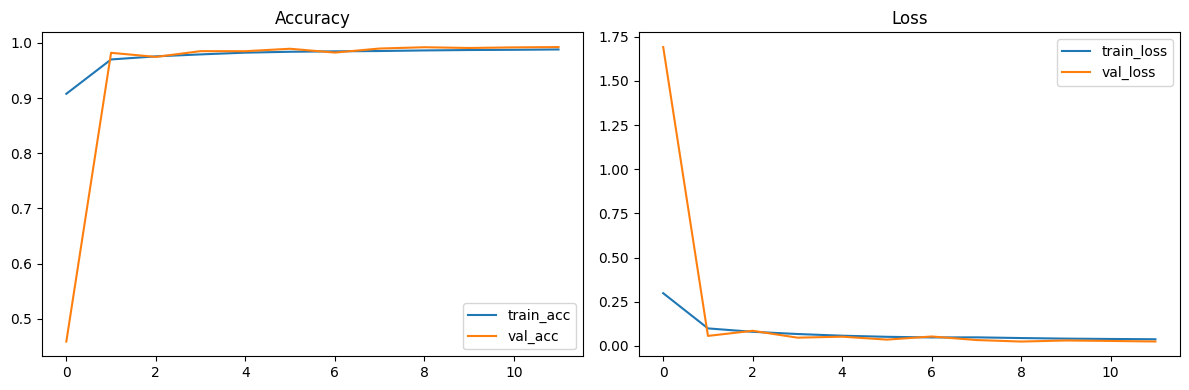

In [ ]:
# ----------------------------
# 12. Plot training curves
# ----------------------------
def plot_history(history):
    fig, axs = plt.subplots(1,2, figsize=(12,4))
    # accuracy
    axs[0].plot(history.history['accuracy'], label='train_acc')
    axs[0].plot(history.history['val_accuracy'], label='val_acc')
    axs[0].set_title('Accuracy')
    axs[0].legend()
    # loss
    axs[1].plot(history.history['loss'], label='train_loss')
    axs[1].plot(history.history['val_loss'], label='val_loss')
    axs[1].set_title('Loss')
    axs[1].legend()
    plt.tight_layout()
    plt.show()

plot_history(history)

# **Model Evaluation**

Test accuracy: 0.9940, Test loss: 0.0200
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


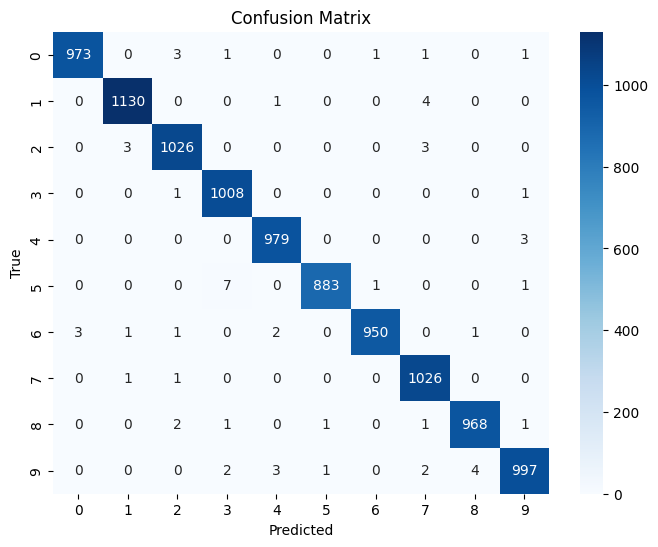

Classification Report:
              precision    recall  f1-score   support

           0     0.9969    0.9929    0.9949       980
           1     0.9956    0.9956    0.9956      1135
           2     0.9923    0.9942    0.9932      1032
           3     0.9892    0.9980    0.9936      1010
           4     0.9939    0.9969    0.9954       982
           5     0.9977    0.9899    0.9938       892
           6     0.9979    0.9916    0.9948       958
           7     0.9894    0.9981    0.9937      1028
           8     0.9949    0.9938    0.9944       974
           9     0.9930    0.9881    0.9906      1009

    accuracy                         0.9940     10000
   macro avg     0.9941    0.9939    0.9940     10000
weighted avg     0.9940    0.9940    0.9940     10000



In [ ]:
# ----------------------------
# 13. Evaluate on test set
# ----------------------------
test_loss, test_acc = model.evaluate(x_test, y_test_cat, verbose=0)
print(f"Test accuracy: {test_acc:.4f}, Test loss: {test_loss:.4f}")

# ----------------------------
# 14. Confusion matrix & classification report
# ----------------------------
y_pred_probs = model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:")
print(classification_report(y_test, y_pred, digits=4))

# **Model Prediction**

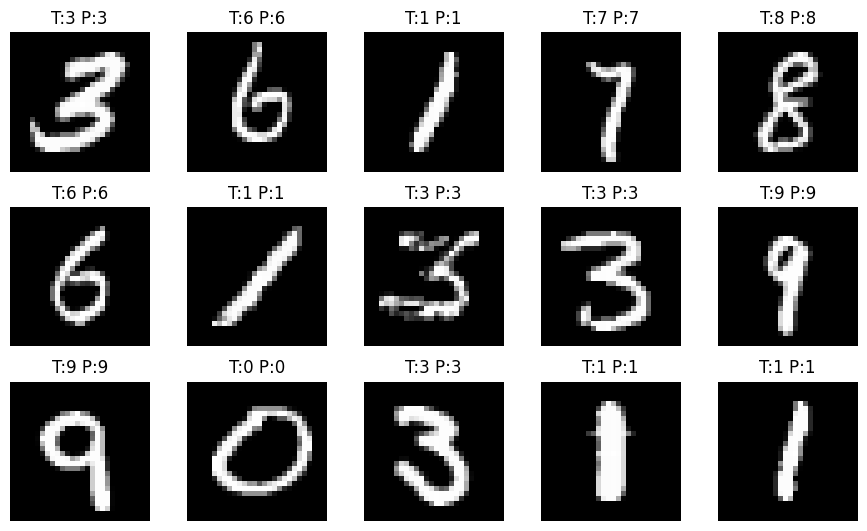

Saved sample images to: output/samples


In [ ]:
# ----------------------------
# 15. Show random predictions (save images for report)
# ----------------------------
def show_predictions(X, y_true, y_pred, n=20):
    idxs = np.random.choice(range(len(X)), n, replace=False)
    cols = 5
    rows = (n + cols - 1) // cols
    plt.figure(figsize=(cols*1.8, rows*1.8))
    for i, idx in enumerate(idxs):
        plt.subplot(rows, cols, i+1)
        plt.imshow(X[idx].squeeze(), cmap='gray')
        plt.title(f"T:{y_true[idx]} P:{y_pred[idx]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show_predictions(x_test, y_test, y_pred, n=15)

# Optionally save a few individual images with predictions to 'output/' for report screenshots
SAMPLES_DIR = OUT_DIR / "samples"
SAMPLES_DIR.mkdir(exist_ok=True)
for i in range(5):
    idx = np.random.randint(0, len(x_test))
    img = (x_test[idx].squeeze() * 255).astype(np.uint8)
    plt.imsave(SAMPLES_DIR / f"sample_{i}_true{y_test[idx]}_pred{y_pred[idx]}.png", img, cmap='gray')

print("Saved sample images to:", SAMPLES_DIR)

# **Save model architecture**

In [ ]:
# ----------------------------
# 16. Save model architecture summary and training history
# ----------------------------
with open(OUT_DIR / "model_summary.txt", "w") as f:
    model.summary(print_fn=lambda x: f.write(x + "\n"))

# Save training history
import json
with open(OUT_DIR / "history.json", "w") as f:
    json.dump(history.history, f)

print("Outputs saved in folder:", OUT_DIR)

Outputs saved in folder: output
